In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
from utils import imshow, show_plot
from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os


In [3]:
class SiameseNetwork(nn.Module):
    """
    Siamese network for image similarity estimation.
    The network is composed of two identical networks, one for each input.
    The output of each network is concatenated and passed to a linear layer.
    The output of the linear layer passed through a sigmoid function.
    `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
    This implementation varies from FaceNet as we use the `ResNet-18` model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
    In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        self.fc_in_features = self.resnet.fc.in_features

        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features
        output = torch.cat((output1, output2), 1)

        # pass the concatenation to the linear layers
        output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output = self.sigmoid(output)

        return output


In [4]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):
        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)


In [5]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    "/Users/liyuxiao/Downloads/nii_project/train_data.csv",
    "/Users/liyuxiao/Downloads/nii_project/dataset/1/",
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataset = SiameseDataset(
    "/Users/liyuxiao/Downloads/nii_project/test_data.csv",
    "/Users/liyuxiao/Downloads/nii_project/dataset/1/",
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

eval_dataset = SiameseDataset(
    "/Users/liyuxiao/Downloads/nii_project/val_data.csv",
    "/Users/liyuxiao/Downloads/nii_project/dataset/1/",
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)


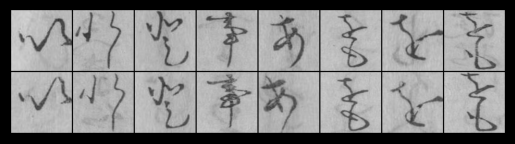

[[1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [6]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())


In [7]:
# create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=1),
            nn.BatchNorm2d(96),
            # nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


In [8]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(
    siamese_dataset, shuffle=True, batch_size=config.batch_size
)
eval_dataloader = DataLoader(eval_dataset, shuffle=True, batch_size=config.batch_size)

test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=config.batch_size)

# Declare Siamese Network
net = SiameseNetwork().cpu()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)


In [11]:
# train the model
def train(train_dataloader):
    loss = []
    counter = []
    iteration_number = 0
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cpu(), img1.cpu(), label.cpu()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean() / len(train_dataloader)


def eval(eval_dataloader):
    loss = []
    counter = []
    iteration_number = 0
    for i, data in enumerate(eval_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cpu(), img1.cpu(), label.cpu()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean() / len(eval_dataloader)


In [12]:
for epoch in range(1, config.epochs):
    best_eval_loss = 9999
    train_loss = train(train_dataloader)
    eval_loss = eval(eval_dataloader)

    print(f"Training loss{train_loss}")
    print("-" * 20)
    print(f"Eval loss{eval_loss}")

    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        print("-" * 20)
        print(f"Best Eval loss{best_eval_loss}")
        torch.save(net.state_dict(), "/content/model.pth")
        print("Model Saved Successfully")


/Users/liyuxiao/opt/anaconda3/envs/nii/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [ ]:
count = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = net(x0.to(device), x1.to(device))

    eucledian_distance = F.pairwise_distance(output1, output2)

    if label == torch.FloatTensor([[0]]):
        label = "Original Pair Of Signature"
    else:
        label = "Forged Pair Of Signature"

    imshow(torchvision.utils.make_grid(concat))
    print("Predicted Eucledian Distance:-", eucledian_distance.item())
    print("Actual Label:-", label)
    count = count + 1
    if count == 10:
        break
